<a href="https://colab.research.google.com/github/steveseguin/measure_frequency_response/blob/main/Frequency_Response_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Setup: Install and Import Necessary Libraries
!pip install numpy scipy matplotlib

import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import re

def process_filename(filename):
    # Remove added numbers in parentheses and file extension
    filename = re.sub(r"\([0-9]+\)", "", filename)  # Remove (1), (2), etc.
    filename = re.sub(r"\.\w+$", "", filename)  # Remove file extension
    return filename

def load_audio(filename):
    samplerate, data = wavfile.read(filename)
    if data.ndim > 1:
        data = data.mean(axis=1)  # Convert to mono if stereo
    return samplerate, data

def fft_analysis(data, samplerate, window=None):
    if window is None:
        # Apply a Hann window by default for better frequency resolution
        window = np.hanning(len(data))

    windowed_data = data * window
    fft_spectrum = rfft(windowed_data)
    freqs = rfftfreq(len(data), 1/samplerate)
    magnitude = np.abs(fft_spectrum)
    return freqs, magnitude

def load_calibration_file(filename):
    calibration_data = {}
    try:
        with open(filename, 'r') as file:
            lines = file.readlines()
            # Skip header if it exists (look for non-numeric content)
            start_line = 0
            for i, line in enumerate(lines):
                parts = line.strip().split()
                if len(parts) >= 2:
                    try:
                        float(parts[0])
                        float(parts[1])
                        start_line = i
                        break
                    except ValueError:
                        continue

            # Process data lines
            for line in lines[start_line:]:
                parts = line.strip().split()
                if len(parts) >= 2:  # Allow for more columns but only use first two
                    try:
                        freq = float(parts[0])
                        correction = float(parts[1])
                        calibration_data[freq] = correction
                    except ValueError:
                        continue  # Skip lines that can't be parsed
    except Exception as e:
        print(f"Error loading calibration file: {e}")

    return calibration_data

def apply_calibration(freqs, magnitude, calibration_data, direction='compensate'):
    if not calibration_data:
        print("Warning: Empty calibration data, returning original magnitude")
        return magnitude

    # Create an interpolator for the calibration data
    calibration_freqs = np.array(list(calibration_data.keys()))
    calibration_corrections = np.array([calibration_data[freq] for freq in calibration_freqs])

    # Sort the calibration data by frequency (important for interpolation)
    sort_idx = np.argsort(calibration_freqs)
    calibration_freqs = calibration_freqs[sort_idx]
    calibration_corrections = calibration_corrections[sort_idx]

    # Check frequency range
    if min(freqs) < min(calibration_freqs) or max(freqs) > max(calibration_freqs):
        print(f"Warning: Some frequencies are outside the calibration range ({min(calibration_freqs)}-{max(calibration_freqs)} Hz)")

    # Create interpolator with appropriate extrapolation
    interpolator = interp1d(
        calibration_freqs,
        calibration_corrections,
        bounds_error=False,
        fill_value=(calibration_corrections[0], calibration_corrections[-1])
    )

    # Apply the calibration correction
    correction_factors = interpolator(freqs)

    # Convert dB to linear scale
    if direction == 'compensate':
        # Divide by the microphone response to flatten it
        corrected_magnitude = magnitude * 10**(-correction_factors/20)
    elif direction == 'enhance':
        # Multiply by the microphone response to emphasize it
        corrected_magnitude = magnitude * 10**(correction_factors/20)
    else:
        raise ValueError("Invalid direction specified. Use 'compensate' or 'enhance'.")

    return corrected_magnitude

def adaptive_smoothing(freqs, response, min_freq=50, max_freq=15000, octave_fraction=3, scale_factor=5):
    """
    Apply frequency-dependent smoothing using a more robust algorithm.

    Args:
        freqs: Frequency array
        response: Response values to smooth
        min_freq: Minimum frequency to consider
        max_freq: Maximum frequency to consider
        octave_fraction: Fraction of an octave to use for window size (higher = smoother)
        scale_factor: Scale factor for window sizes

    Returns:
        Smoothed response array
    """
    valid_idx = (freqs >= min_freq) & (freqs <= max_freq)
    valid_freqs = freqs[valid_idx]
    valid_response = response[valid_idx]

    smoothed = np.zeros_like(valid_response)

    # For each frequency point
    for i, freq in enumerate(valid_freqs):
        # Calculate the window size in Hz based on the current frequency
        # Window size is proportional to frequency (constant in log space)
        window_width_hz = freq / octave_fraction

        # Find all points within this window
        window_idx = (valid_freqs >= (freq - window_width_hz/2)) & (valid_freqs <= (freq + window_width_hz/2))

        # Calculate weighted average (points closer to the center have higher weight)
        if np.sum(window_idx) > 0:
            window_freqs = valid_freqs[window_idx]
            window_response = valid_response[window_idx]

            # Calculate distance-based weights (closer points have higher weight)
            distances = np.abs(window_freqs - freq) / (window_width_hz/2)
            weights = np.exp(-scale_factor * distances)

            # Apply weighted average
            smoothed[i] = np.sum(window_response * weights) / np.sum(weights)
        else:
            smoothed[i] = valid_response[i]

    # Prepare output array with same shape as input
    result = np.copy(response)
    result[valid_idx] = smoothed

    return result

def calculate_frequency_response(test_magnitude, ref_magnitude, db_limit=60):
    """
    Calculate frequency response with proper handling of very small values

    Args:
        test_magnitude: Test microphone magnitude spectrum
        ref_magnitude: Reference microphone magnitude spectrum
        db_limit: Maximum dB difference to allow (prevents division by very small numbers)

    Returns:
        Frequency response in dB
    """
    # Add a small value to prevent division by zero
    epsilon = np.max(ref_magnitude) * 1e-10

    # Calculate ratio and convert to dB
    ratio = np.divide(test_magnitude, ref_magnitude + epsilon)

    # Convert to dB
    response_db = 20 * np.log10(ratio)

    # Limit extreme values
    response_db = np.clip(response_db, -db_limit, db_limit)

    return response_db

def plot_frequency_response(freqs, original_response, smoothed_response,
                           ref_filename, test_filename, min_freq=50, max_freq=15000,
                           calibration_status="Not Calibrated"):
    """
    Plot the frequency response curves with appropriate formatting
    """
    plt.figure(figsize=(12, 8))

    # Filter to the desired frequency range
    valid_idx = (freqs >= min_freq) & (freqs <= max_freq)

    # Original curve (with lower alpha)
    plt.semilogx(freqs[valid_idx], original_response[valid_idx], 'b-', alpha=0.4, linewidth=1, label='Original')

    # Smoothed curve (more prominent)
    plt.semilogx(freqs[valid_idx], smoothed_response[valid_idx], 'r-', linewidth=2, label='Smoothed')

    # Add frequency markers at octaves
    octaves = [31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
    plt.xticks(octaves, [str(oct) for oct in octaves])

    # Add zero reference line
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)

    # Grid settings
    plt.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.7)
    plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

    # Labels and title
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.title('Microphone Frequency Response')

    # Add 10dB spacing lines
    for db in range(-50, 51, 10):
        plt.axhline(y=db, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)

    # Metadata annotation
    ref_filename_proc = process_filename(ref_filename)
    test_filename_proc = process_filename(test_filename)
    metadata_str = f"Reference: {ref_filename_proc} ({calibration_status})\nTest: {test_filename_proc}"
    plt.figtext(0.5, 0.01, metadata_str, ha="center", fontsize=9,
                bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    plt.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Make room for the metadata text

    return plt.gcf()  # Return the figure for further customization

In [4]:
# Upload Audio Files
print("Upload your reference audio file (with a known flat-response microphone recording):")
uploaded_ref = files.upload()
reference_filename = list(uploaded_ref.keys())[0]
samplerate_ref, data_ref_unclipped = load_audio(reference_filename)
reference_filename_processed = process_filename(reference_filename)
data_ref = None # clear
uploaded_calibration = None # clear

Upload your reference audio file (with a known flat-response microphone recording):


Saving 0.wav to 0.wav


In [5]:
print("Upload your test microphone audio file:")
uploaded_test = files.upload()
test_filename = list(uploaded_test.keys())[0]
samplerate_test, data_test_unclipped = load_audio(test_filename)
test_filename_processed = process_filename(test_filename)
data_test = None # clear

Upload your test microphone audio file:


Saving x3.wav to x3.wav


In [6]:
# Trim to match lengths
min_length = min(len(data_ref_unclipped), len(data_test_unclipped))
data_ref = data_ref_unclipped[:min_length]
data_test = data_test_unclipped[:min_length]

# Apply window before FFT for better frequency resolution
window = np.hanning(min_length)

# Calculate the Frequency Response
freqs_ref, magnitude_ref = fft_analysis(data_ref, samplerate_ref)
freqs_test, magnitude_test = fft_analysis(data_test, samplerate_test)

calibration_data = {}
calibration_status = "Not Calibrated"

In [7]:

# This step is only if you have a calibration file
try:
    print("Upload your reference mic's calibration file (if available, otherwise skip):")
    uploaded_calibration = files.upload()

    if uploaded_calibration:
        calibration_filename = list(uploaded_calibration.keys())[0]
        calibration_data = load_calibration_file(calibration_filename)

        if calibration_data:
            # Apply calibration to reference mic spectrum
            magnitude_ref = apply_calibration(freqs_ref, magnitude_ref, calibration_data)
            calibration_status = "Calibrated"
            print(f"Calibration applied with {len(calibration_data)} data points")
        else:
            print("Warning: Calibration file was empty or could not be parsed")
except Exception as e:
    print(f"No calibration file uploaded or error: {str(e)}")

Upload your reference mic's calibration file (if available, otherwise skip):


Saving 28821.txt to 28821.txt
Calibration applied with 256 data points


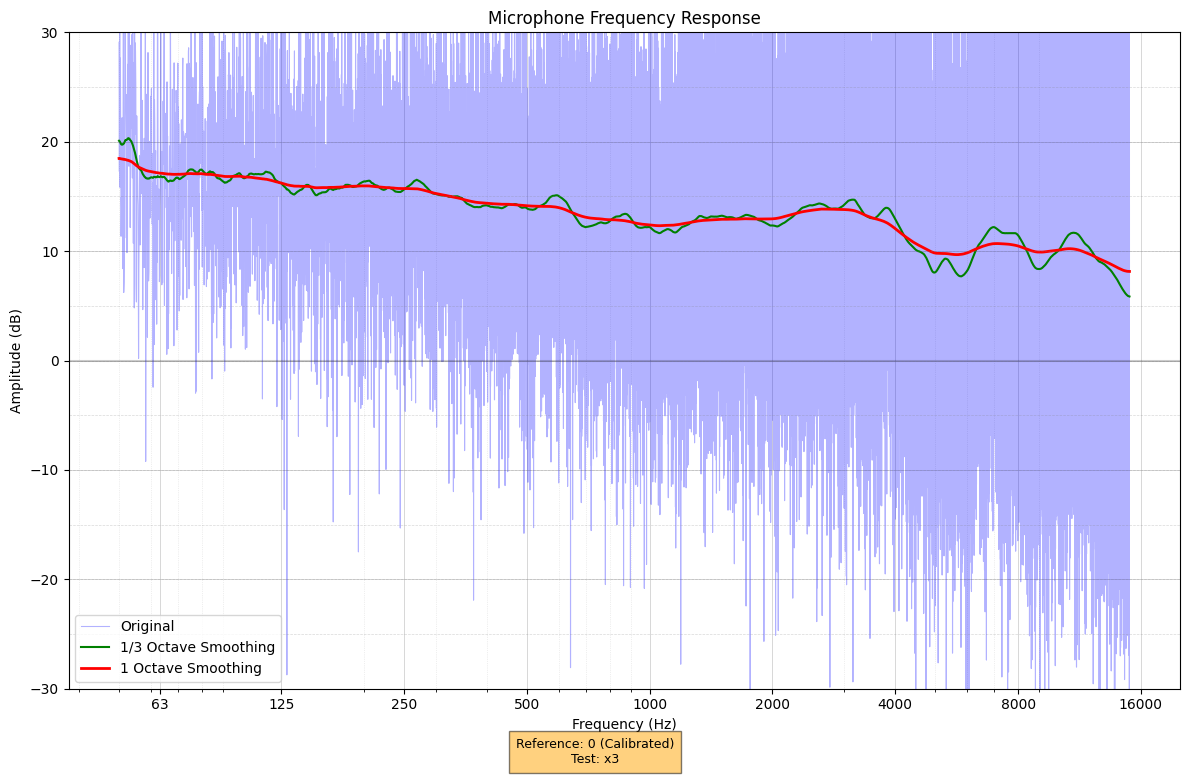

<Figure size 640x480 with 0 Axes>

In [12]:
# Calculate frequency response (ratio of test to reference)
frequency_response = calculate_frequency_response(magnitude_test, magnitude_ref)

# Define frequency limits
lower_limit_freq = 50     # Lower frequency limit in Hz
upper_limit_freq = 15000  # Upper frequency limit in Hz

# Filter to frequency range of interest
valid_indices = (freqs_ref >= lower_limit_freq) & (freqs_ref <= upper_limit_freq)
filtered_freqs = freqs_ref[valid_indices]
filtered_response = frequency_response[valid_indices]

# Apply adaptive smoothing with better parameters for audio analysis
# First pass - heavy smoothing for trend visualization
smoothed_response_heavy = adaptive_smoothing(
    freqs_ref,
    frequency_response,
    min_freq=lower_limit_freq,
    max_freq=upper_limit_freq,
    octave_fraction=1,    # 1 = 1 octave smoothing (very smooth)
    scale_factor=3
)

# Second pass - moderate smoothing for more accurate visualization
smoothed_response_medium = adaptive_smoothing(
    freqs_ref,
    frequency_response,
    min_freq=lower_limit_freq,
    max_freq=upper_limit_freq,
    octave_fraction=3,    # 1/3 octave smoothing (audio standard)
    scale_factor=4
)


# Plot the results - original and both smoothing levels
plt.figure(figsize=(12, 8))

# Filter to the desired frequency range
valid_idx = (freqs_ref >= lower_limit_freq) & (freqs_ref <= upper_limit_freq)

# Original curve (with lower alpha)
plt.semilogx(freqs_ref[valid_idx], frequency_response[valid_idx],
             'b-', alpha=0.3, linewidth=0.8, label='Original')

# Medium smoothing
plt.semilogx(freqs_ref[valid_idx], smoothed_response_medium[valid_idx],
             'g-', linewidth=1.5, label='1/3 Octave Smoothing')

# Heavy smoothing
plt.semilogx(freqs_ref[valid_idx], smoothed_response_heavy[valid_idx],
             'r-', linewidth=2, label='1 Octave Smoothing')

# Add frequency markers at standard octaves
octaves = [63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
plt.xticks(octaves, [str(oct) for oct in octaves])

# Add zero reference line
plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)

# Grid settings
plt.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

# Labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.title('Microphone Frequency Response')

# Add 5dB spacing lines
for db in range(-30, 31, 5):
    plt.axhline(y=db, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)

# Y-axis limits (adjust as needed for your data)
plt.ylim(-30, 30)

# Metadata annotation
metadata_str = f"Reference: {reference_filename_processed} ({calibration_status})\nTest: {test_filename_processed}"
plt.figtext(0.5, 0.01, metadata_str, ha="center", fontsize=9,
            bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Make room for the metadata text

plt.show()

# Save the plot if desired
plt.savefig(f"{test_filename_processed}_vs_{reference_filename_processed}.png", dpi=300)
